Make T-q plot at time of Twbmax
-

In [1]:
import sys
import os
import argparse
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D

from config import *
from utils.wetbulb_dj08_spedup import WetBulb
from utils.hi_formula import *
from CP4.compute_twb.compute_rh import get_rh
from CP4.make_climato.a1_compute_rolling_mean_var import load_var_roll_mean
from CP4.make_climato.a2_compute_rolling_mean_proc_var import load_proc_var_roll_mean
from CP4.make_climato.c1_compute_running_hourly_climato_single_lvl_var import load_single_lvl_var_running_hclimato
from CP4.treat_max.a_make_dmax_proc_var import load_proc_var_dmax
from CP4.make_composites.make_hhee_data import get_files_hhee_data, load_hhee_data
from CP4.make_composites.a1_make_var_field import load_composite_ids_hhee
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
### CST ###

t_var = 't2'
q_var = 'q2'

#~ for computing isolines of constant Twb for a range of (T, q)
trange = np.arange(24., 36.+0.01, 0.01)
qrange = np.arange(0.0125, 0.028+0.0001, 0.0001)
twbrange = np.arange(24, 30+1, 1)
rh2plot = np.arange(40, 100+20, 20)

trangefh = Tcelsius_to_farhenheit(trange)
hirange = np.arange(26, 50+2, 2)

htwb = Line2D([0], [0], linewidth=1, linestyle='-', color='olive', label='Twb')
hhi = Line2D([0], [0], linewidth=1, linestyle='--', color='cyan', label='HI')
hrh = Line2D([0], [0], linewidth=1, linestyle='-.', color='purple', label='RH')

hcaution = mpatches.Patch(linewidth=0, color='yellow', alpha=0.5, label='Caution')
hextcaut = mpatches.Patch(linewidth=0, color='orange', alpha=0.5, label='Extreme Caution')
hdanger = mpatches.Patch(linewidth=0, color='orangered', alpha=0.5, label='Danger')

In [26]:
ds='CP4A'
res=4
var='twb'
window=6
dwindow=11
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
lat_range=[2., 12.]
lon_range=[-8., 10.]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.   # km2
max_hw_size=1000000.   # km2
sw=[4., 4.]
tw=[-72, 72]
n_days=3
meth='cc3d'
cnty=26
flabel='b'

In [17]:
res_ = str(res) + 'km'

years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

lat_min = lat_range[0]
lat_max = lat_range[1]
assert lat_min < lat_max, "incorrect latitude range"
lon_min = lon_range[0]
lon_max = lon_range[1]
assert lon_min < lon_max, "incorrect longitude range"

if meth == 'cc3d':
    meth_ = '_' + meth + '=' + str(cnty)
else:
	meth_ = meth

if lat_range == [-6., 6.]:
    p = 96548  # -> at center point  / 96126   # -> mean surface pressure across events climatology + spatial mean + time mean
    ttl = 'CAfr'
elif lat_range == [2., 12.]:
    p = 99468  # 99500  # 98478.5
    ttl = 'Guinea'

In [7]:
#~ Compute Twb & HI for a range of (t, q) values

out_twb = {}
out_hi = {}
out_rh = {}

for t, tfh in zip(trange, trangefh):
    rhrange = get_rh(t, qrange, p, 'pa')
    irhrange = np.where(rhrange < 100)[0]
    rhrange_ = rhrange[irhrange]
    qrange_ = qrange[irhrange]

    twb = [WetBulb(t, p, q, 0)[0] for q in qrange_]
    out_twb[t] = pd.DataFrame(data=twb, index=qrange_, columns=['twb'])
    out_rh[t] = pd.DataFrame(data=rhrange_, index=qrange_, columns=['rh'])

    hifh_simple = np.array([compute_hi_simple(tfh, rh) for rh in rhrange_])

    # Compute HI values > 80 -> full regression + adjustments (if needed)
    inds_hi_regr = np.where(hifh_simple > 80.)
    if not len(inds_hi_regr[0]) == 0:
        rhrange_regr = rhrange_[inds_hi_regr]
        hi_regr = compute_hi(tfh, rhrange_regr)
        hifh_simple[inds_hi_regr] = hi_regr

        # check for adjustments !!!
        if 80 < tfh < 112:
            inds_rh_adj1 = np.where(rhrange_regr < 13.)
            adj1 = get_adjustment1(tfh, rhrange_regr[inds_rh_adj1])
            hi_regr_adj1 = hi_regr[inds_rh_adj1] - adj1
            hifh_simple[inds_rh_adj1] = hi_regr_adj1
        elif 80 < tfh < 87:
            inds_rh_adj2 = np.where(rhrange_regr > 85.)
            adj2 = get_adjustment2(tfh, rhrange_regr[inds_rh_adj2])
            hi_regr_adj2 = hi_regr[inds_rh_adj2] + adj2
            hifh_simple[inds_rh_adj2] = hi_regr_adj2

    hic = Tfarhenheit_to_celsius(hifh_simple)
    out_hi[t] = pd.DataFrame(data=hic, index=qrange_, columns=['hi'])

df_twb = pd.concat(out_twb)
df_rh = pd.concat(out_rh)
df_hi = pd.concat(out_hi)

In [18]:
#~ Get data

dmax = load_proc_var_dmax(ds, res, var, window, y0, y1, months, lat_range, lon_range)
ids = load_composite_ids_hhee(ds, res, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)
t2clim = load_single_lvl_var_running_hclimato(ds, res, 't2', y0, y1, window, months, lat_range, lon_range)
q2clim = load_single_lvl_var_running_hclimato(ds, res, 'q2', y0, y1, window, months, lat_range, lon_range)

files = get_files_hhee_data(ds, res, var, months, lat_range, lon_range, min_hw_size, max_hw_size, t_thresh, q_thresh, n_days, meth)
files.sort()

file = CP4OUTPATH + '/' + ds + '/' + res_ + '/composites_' + var + '/hhe_tables/lat={0},{1}_lon={2},{3}'.format(lat_min,lat_max,lon_min,lon_max) + '/' + months_ + '/' + space_scale + '/twb_thres=' + str(t_thresh) + '_q_thres=' + str(q_thresh) + '_n_days=' + str(n_days) + meth_

files_ = []
for f in files:
    for id in ids:
        if f == file + '/' + id + '.p':
            files_.append(f)

nfs = len(files_)
print('>>> {0} events <<<'.format(nfs))

iyrs = dmax.groupby('time.year').groups
idayc = (months[0]-1) * 30 + int(dwindow/2)  # index of the first day of climatology

t2s = []
q2s = []
t2s_hhee = []
q2s_hhee = []
twbs_hhee = []
his_hhee = []

>>> 637 events <<<


In [19]:
for ifile, f in enumerate(files_):
    print(ifile, end=' : ', flush=True)

    hhee = load_hhee_data(f)

    datestr = hhee['date']
    y = int(datestr[0:4])
    m = int(datestr[5:7])
    d = int(datestr[8:10])
    tmaxlat = hhee['tmaxlat']
    tmaxlon = hhee['tmaxlon']
    tmax = hhee['tmax']

    im = np.where(np.asarray(months) == m)[0][0]
    iday = (m-1)*30+d-1
    i = iday - idayc

    ydmax = dmax.isel(time=iyrs[y]).sel(latitude=tmaxlat, longitude=tmaxlon, method='nearest')
    imths = ydmax.groupby('time.month').groups
    mdmax = ydmax.isel(time=imths[m])
    idays = mdmax.groupby('time.day').groups
    ddmax = mdmax.isel(time=idays[d])

    t2clim_ = t2clim.sel(latitude=tmaxlat, longitude=tmaxlon, method='nearest').isel(days=i)
    q2clim_ = q2clim.sel(latitude=tmaxlat, longitude=tmaxlon, method='nearest').isel(days=i)
    assert (t2clim_.time_level_0 == m) and (t2clim_.time_level_1 == d)

    # get time of Twbmax from hourly data
    twbdata = load_proc_var_roll_mean(ds, res, var, y, window, months, lat_range, lon_range)
    twbmax_ = twbdata.sel(latitude=tmaxlat, longitude=tmaxlon, method='nearest')
    imthsmax = twbmax_.groupby('time.month').groups
    twbmax_ = twbmax_.isel(time=imthsmax[m])
    idaysmax = twbmax_.groupby('time.day').groups
    twbmax_ = twbmax_.isel(time=idaysmax[d])
    imax = np.argmax(twbmax_.values)

    twbs_hhee.append(twbmax_[imax].values)

    t2clim_max = t2clim_.isel(hour=imax)
    q2clim_max = q2clim_.isel(hour=imax)

    assert (ddmax.values == tmax) and (twbmax_.max() == tmax)

    t2 = load_var_roll_mean(ds, res, 't2', y, window, months, lat_range, lon_range)
    q2 = load_var_roll_mean(ds, res, 'q2', y, window, months, lat_range, lon_range)

    t2_hhee = t2.sel(latitude=tmaxlat, longitude=tmaxlon, time=twbmax_.time[imax].values, method='nearest')
    q2_hhee = q2.sel(latitude=tmaxlat, longitude=tmaxlon, time=twbmax_.time[imax].values, method='nearest')
    t2s_hhee.append(t2_hhee.values)
    q2s_hhee.append(q2_hhee.values)

    t2ano = t2_hhee - t2clim_max
    q2ano = q2_hhee - q2clim_max

    #print('\n>>> {0} {1}h: {2} ({3}) | {4} ({5}) <<<'.format(datestr, imax, t2_hhee.values, t2ano.values, q2_hhee.values, q2ano.values))

    psrfc = load_var_roll_mean(ds, res, 'p_srfc', y, window, months, lat_range, lon_range)
    psrfc_hhee = psrfc.sel(latitude=tmaxlat, longitude=tmaxlon, time=twbmax_.time[imax].values, method='nearest')

    # Compute HI for event
    tfh_hhee = Tcelsius_to_farhenheit(t2_hhee-273.15)
    rh_hhee = get_rh(t2_hhee-273.15, q2_hhee, psrfc_hhee, 'pa')
    hifh_simple = compute_hi_simple(tfh_hhee, rh_hhee)

    # Compute HI values > 80 -> full regression + adjustments (if needed)
    if hifh_simple > 80:
        hi_regr = compute_hi(tfh_hhee, rh_hhee)
        hifh_simple = hi_regr

    # check for adjustments !!!
    if (80 < tfh_hhee < 112) and (rh_hhee < 13.):
        adj1 = get_adjustment1(tfh_hhee, rh_hhee)
        hi_regr_adj1 = hi_regr - adj1
        hifh_simple = hi_regr_adj1
    elif (80 < tfh_hhee < 87) and (rh_hhee > 85.):
        adj2 = get_adjustment2(tfh_hhee, rh_hhee)
        hi_regr_adj2 = hi_regr + adj2
        hifh_simple = hi_regr_adj2

    hi_hhee = Tfarhenheit_to_celsius(hifh_simple)

    his_hhee.append(hi_hhee)

In [20]:
t2s = np.asarray(t2s) - 273.15
q2s = np.asarray(q2s)
t2s_hhee = np.asarray(t2s_hhee) - 273.15
q2s_hhee = np.asarray(q2s_hhee)

df = pd.DataFrame({'t2': t2s, 'q2': q2s})
df_hhee = pd.DataFrame({'t2': t2s_hhee, 'q2': q2s_hhee})

t2med = np.nanmedian(t2s)
q2med = np.nanmedian(q2s)
t2std = np.nanstd(t2s)
q2std = np.nanstd(q2s)
t2hheemed = np.nanmedian(t2s_hhee)
q2hheemed = np.nanmedian(q2s_hhee)
t2hheestd = np.nanstd(t2s_hhee)
q2hheestd = np.nanstd(q2s_hhee)
t2diff = t2hheemed - t2med
q2diff = (q2hheemed - q2med) * 1000
q2diffrel = q2diff / (q2med*1000) * 100

twbs_hhee = np.asarray(twbs_hhee)

his_hhee = np.asarray(his_hhee)
his_hhee_all = np.copy(his_hhee)
his_hhee[his_hhee < 33] = np.nan
his_hhee_caution = his_hhee[his_hhee < 40]
his_hhee_danger = his_hhee[his_hhee >= 40]

p_caution = len(his_hhee_caution) / len(his_hhee_all) * 100
p_danger = len(his_hhee_danger) / len(his_hhee_all) * 100

/home/users/guicha/conda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/users/guicha/conda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


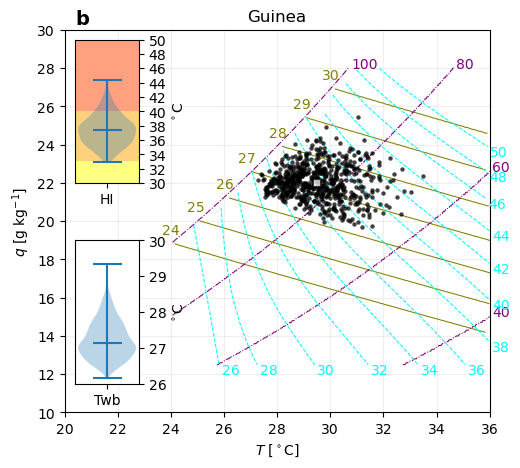

In [27]:
#~ Plot

fig, ax = plt.subplots()

plt.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95)

for twb in twbrange:
    tq = df_twb.query('{0} <= twb < {0}+0.01'.format(twb)).index.values
    ts = np.array([tq_[0] for tq_ in tq])
    qs = np.array([tq_[1] for tq_ in tq])

    ax.plot(ts, qs, lw=0.75, color='olive', label=int(twb))
    ax.text(ts.min()-0.5, qs.max()+0.0005, twb, color='olive')

for rh in rh2plot:
    tq = df_rh.query('{0}-0.1 <= rh < {0}+0.1'.format(rh)).index.values
    ts = np.array([tq_[0] for tq_ in tq])
    qs = np.array([tq_[1] for tq_ in tq])

    ax.plot(ts, qs, lw=0.75, color='purple', label=int(rh), ls='-.')
    ax.text(ts.max()+0.1, qs.max()+0.00001, rh, color='purple')

for hi in hirange:
    tq = df_hi.query('{0} <= hi < {0}+0.01'.format(hi)).index.values
    ts = np.array([tq_[0] for tq_ in tq])
    qs = np.array([tq_[1] for tq_ in tq])

    ax.plot(ts, qs, lw=0.75, color='cyan', label=int(hi), ls='--')
    ax.text(ts.max()+0.1, qs.min()-0.0005, hi, color='cyan')


df_hhee.plot.scatter('t2', 'q2', ax=ax, c='k', s=10, linewidth=0, alpha=0.75, zorder=500)

ax.scatter(t2hheemed, q2hheemed, marker='s', color='w', edgecolors='k', linewidths=1.5, s=35, alpha=0.75, zorder=1000)
ax.text(0.025, 1.015, flabel, weight="bold", fontsize=14, transform=ax.transAxes)

ytcks = ax.get_yticks()
ytlbs = [int(yt * 1000) for yt in ytcks]

ax.set_xlim(20., 36.)
ax.set_xlabel('$T$ [$^\circ$C]')
ax.set_ylim(0.01, 0.028)
ax.set_yticks(ytcks)
ax.set_yticklabels(ytlbs)
ax.set_ylabel('$q$ [g kg$^{-1}$]')
ax.set_title(ttl)
ax.grid(True, alpha=0.2)

axins = ax.inset_axes([0.025, 0.6, 0.15, 0.375])

axins.violinplot(his_hhee_all, showmedians=True)

ytcks = np.arange(30, 50+2, 2)
xlims = axins.get_xlim()

axins.fill_between(x=[xlims[0], xlims[1]], y1=ytcks[0], y2=33, color='yellow', alpha=0.5, linewidths=0., zorder=0)
axins.fill_between(x=[xlims[0], xlims[1]], y1=33, y2=40, color='orange', alpha=0.5, linewidths=0., zorder=0)
axins.fill_between(x=[xlims[0], xlims[1]], y1=40, y2=ytcks[-1], color='orangered', alpha=0.5, linewidths=0., zorder=0)

axins.set_xticks([1.])
axins.set_xticklabels(['HI'])
axins.set_xlim(xlims)
axins.set_ylabel('$^\circ$C')
axins.set_yticks(ytcks)
axins.set_yticklabels(ytcks)
axins.yaxis.set_label_position("right")
axins.yaxis.tick_right()
axins.set_ylim((ytcks[0], ytcks[-1]))

axins2 = ax.inset_axes([0.025, 0.075, 0.15, 0.375])

axins2.violinplot(twbs_hhee, showmedians=True)

ytcks = np.arange(26, 30+1, 1)
xlims = axins2.get_xlim()

axins2.set_xticks([1.])
axins2.set_xticklabels(['Twb'])
axins2.set_xlim(xlims)
axins2.set_ylabel('$^\circ$C')
axins2.set_yticks(ytcks)
axins2.set_yticklabels(ytcks)
axins2.yaxis.set_label_position("right")
axins2.yaxis.tick_right()

fig.set_size_inches(5., 4.5)

(0.0, 1.0, 0.0, 1.0)

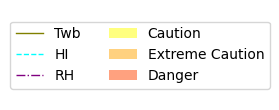

In [23]:
fig_leg, ax_leg = plt.subplots(figsize=(2.75, 1.))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

ax_leg.legend(handles=[htwb, hhi, hrh, hcaution, hextcaut, hdanger], loc='center', ncol=2)  # , hsmall, hlarge
ax_leg.axis('off')